In [30]:
#importing modules 
import json 
import pandas as pd
import numpy as np
import csv
from fuzzywuzzy import fuzz, process
import re
from timeit import default_timer as timer
import random
import matplotlib.pyplot as plt
from itertools import islice
import pkg_resources
from symspellpy import SymSpell, Verbosity

# test file path
path = "./test_directory_files/"
tsv = "tsv/"
locations = "4b119360-317a-0134-9131-00505686a51c_locations.tsv"
occupations = "4b119360-317a-0134-9131-00505686a51c_occupations.tsv"
subjects = "4b119360-317a-0134-9131-00505686a51c_subjects.tsv"
test_json = "119.56837603.5abc93e0-6e04-0134-173e-00505686a51c_labeled.json"
street_names_txt = "./city-directory-entry-parser-master/streetnames.txt"

sym_spell = SymSpell()
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, 0, 1)

# set seed
random.seed(160220)

In [31]:
# Print out first 5 elements to demonstrate that dictionary is
# successfully loaded
##print(list(islice(sym_spell.words.items(), 5)))

In [32]:
# Open tsvs and streetnames
## From Nick: Columns are the directory uuid, page uuid, entry uuid, the number (in 0,1,2,3 index order) of the entry 
##            (remember that there could be more than one subject per entry, more than one occupation, etc.).Most are 
##            entry 0, but sometimes you might find an entry 1 if there are multiple subjects/occupations/locations. 
##            Then an offset number, e.g. the order of the token from the start of the entry. So a 0th token, 1st token,
##            2nd token, etc. And finally the token itself in the last column.
##            Remember that we have to keep that entry and offset number linked to each token otherwise we won't be able 
##            to swap any corrections back into the JSON file once we have a listed of recommended edits.

locations_tsv = pd.read_csv(path + tsv + locations, 
                           sep = "\t",
                           quoting = csv.QUOTE_NONE)
occupations_tsv = pd.read_csv(path + tsv + occupations, 
                           sep = "\t",
                           quoting = csv.QUOTE_NONE)
subjects_tsv = pd.read_csv(path + tsv + subjects, 
                           sep = "\t",
                           quoting = csv.QUOTE_NONE)
master_street_names = pd.read_csv(street_names_txt, 
                                  header = None)
master_street_names = master_street_names[0].tolist()
#master_street_names

### Locations

**Objectives:**  
1) Find common Tesseract tokens  
2) Assign level of confidence  
3) Swap out those with high level of confidence  

In [33]:
print(locations_tsv.entry_uuid.nunique())
#locations_tsv.head(n = 20)

164451


In [34]:
# function remove punctuation and default to lowercase
def clean_token(token):
    token_lower = token.lower()
    token_clean = ''.join(t for t in token_lower if t.isalnum())
    return token_clean

# apply to column and create new column
locations_tsv["token_re"] = locations_tsv["token"].apply(clean_token)

# drop rows with just whitespace
locations_tsv = locations_tsv.drop(locations_tsv[(locations_tsv.token_re == '')].index)

# create trial pd
locations_tsv_trunc = locations_tsv.sample(n = 500)
#locations_tsv_trunc.head(n=50)

#### Fuzzywuzzy
The following trials a fuzzy matching approach to the problem of correcting location entries based on a dictionary of known street names.   
The threshold is set at 90%. Only entries that are at least 90% similar to the list of known locations are successfully replaced. 

In [35]:
# timer
start = timer()

# Create lists for similar and dissimilar tokens
tesseract_s = []
pct_similarity_s = []
best_guess_s = []
tesseract_d = []
pct_similarity_d = []
best_guess_d = []
def fuzzy_match(x, choices=master_street_names, scorer=fuzz.token_sort_ratio, threshold = 90,
                tesseract_s = tesseract_s, pct_similarity_s = pct_similarity_s, best_guess_s = best_guess_s,
                tesseract_d = tesseract_d, pct_similarity_d = pct_similarity_d, best_guess_d = best_guess_d):
    n = 0
    # check if numeric:
    digit_check = x.isdigit()
    if digit_check is True:
        return x
    else:
        best_guess, pct_similarity = process.extractOne(x, choices=choices, scorer=scorer)
        if pct_similarity >= threshold:
            tesseract_s.append(x)
            pct_similarity_s.append(pct_similarity)
            best_guess_s.append(best_guess)
            return best_guess
        else:
            tesseract_d.append(x)
            pct_similarity_d.append(pct_similarity)
            best_guess_d.append(best_guess)
            return None
            
        #print(best_guess)
        #print(pct_similarity)

        
        
# create a second truncated df to trial
locations_tsv_trunc_2 = locations_tsv_trunc
    
# Following post explains why token_sort_ratio might be best 
## https://medium.com/analytics-vidhya/matching-messy-pandas-columns-with-fuzzywuzzy-4adda6c7994f
## tldr: converts each word to a token, then sorts aphabetically. 
## Streetnames that are abbrievated and in full both start with the same letter so this avoids errors like bway -> w  

#### FULL DATASET

locations_tsv["token_replaced"] = locations_tsv["token_re"].apply(
    fuzzy_match
    ,args=(
        master_street_names,
        fuzz.token_sort_ratio
    )
)
 
#### SAMPLE DATASET  

# locations_tsv_trunc["token_replaced"] = locations_tsv_trunc["token_re"].apply(fuzzy_match)
    
## timer
end = timer()
print(end - start)

1501.1046900000001


In [36]:
# Put the lists from replacement fn above into a df
## Dissimilarity
dissimilar_frequency_df = pd.DataFrame({"Tesseract": tesseract_d,
                    "Guess": best_guess_d,
                    "Similarity": pct_similarity_d}) 
## Similarity
similar_frequency_df = pd.DataFrame({"Tesseract": tesseract_s,
                    "Guess": best_guess_s,
                    "Similarity": pct_similarity_s}) 

In [37]:
similar_frequency_df

,Tesseract,Guess,Similarity
0,elm,Elm,100
1,madison,Madison,100
2,seventh,Seventh,100
3,av,Av,100
4,first,First,100
...,...,...,...
247388,mott,Mott,100
247389,third,Third,100
247390,av,Av,100
247391,w,W,100


The histogram suggests that for most replacement tokens, there is little variance in the tokens they replace. When performing swaps at a very high confidence level as measured by the degree of similarity, it is mostly a 1:1 swap. The case where a swap replaces multiple Tesseract tokens does not occur too frequently and rapidly drops off.  
There are 804 unique Tesseract tokens in this directory. 600 of them show up less than or equal to 150 times. Some, such as "w" and "av" show up more than 20,000 times.
The mean number of unique Tesseract tokens each replacement accounts for is **2.16**. For example, "Ave" might be the replacement for "av" and "ave" only, even we know that "av" alone shows up more than 20,000 times.  
This implies that Tesseract is consistent in its recognition of text.

Text(0, 0.5, 'Count')

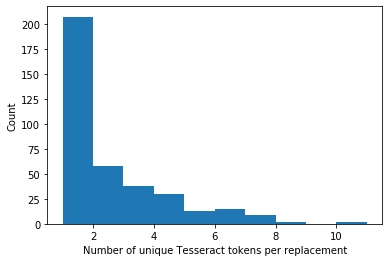

In [38]:
similar_frequency_df2 = similar_frequency_df.groupby("Guess", as_index = True).Tesseract.nunique()
# similar_frequency_df2
#similar_frequency_df2.mean()
plt.hist(similar_frequency_df2)
plt.xlabel("Number of unique Tesseract tokens per replacement")
plt.ylabel("Count")

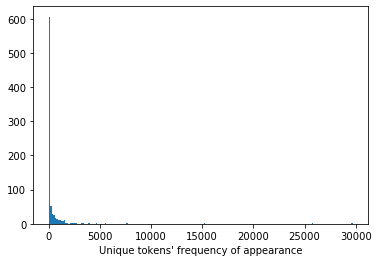

In [39]:
tesseract_frequency = similar_frequency_df.Tesseract.value_counts()
plt.hist(tesseract_frequency, 200)
plt.xlabel("Unique tokens' frequency of appearance")
#plt.show suppresses the annoying array printout
plt.show()

The scatter plot below plots number of unique Teseract tokens for each replacement token against the mean of the degree to which they are similar. The histogram above suggests that there are many 1:1 unique replacements. However, the degrees of similarities are very much clustered and show little variance as compared to the other replacement tokens. Suprisingly, the mean degree of similarity are rather *uniformly high*. 

Text(0, 0.5, 'Degree similarity (%)')

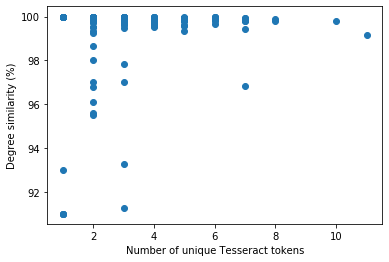

In [40]:
## agg fn allows insertion of functions or list of functions which are then returned as multindex cols
similar_frequency_df3 = similar_frequency_df.groupby("Guess", as_index = False).agg({
    "Tesseract": "nunique",
    "Similarity": "mean"
})
plt.scatter(similar_frequency_df3.Tesseract, similar_frequency_df3.Similarity)
plt.xlabel("Number of unique Tesseract tokens")
plt.ylabel("Degree similarity (%)")

In [41]:
similar_frequency_df3

,Guess,Tesseract,Similarity
0,10th,1,100.00
1,11th,1,100.00
2,12th,1,100.00
3,13th,1,100.00
4,14th,1,100.00
...,...,...,...
369,roof,1,100.00
370,store,1,91.00
371,the,1,100.00
372,under,3,93.25


In [42]:
similar_frequency_df.groupby("Tesseract").count()

,Guess,Similarity
Tesseract,,
10th,439,439
11th,1534,1534
12birmingham,1,1
12th,1698,1698
13th,1150,1150
...,...,...
wunder,2,2
xchange,8,8
york,82,82


As compared to the highly similar tokens and their replacements, the number of unique Tesseract tokens for each **dissimilar** replacement token has increased dramatically. But at the same time, most Tesseract tokens occur at very low frequencies. That is to say, Tesseract's recognition and rendition of these tokens is inconsistent. This interpretation of the data implies that the master list against which this is compared is exhaustive and correct; as a result, if Tesseract is consistent, there should be less unique tokens, but they should occur more frequently.  
On the other hand, it might just be the case that the master list is *non-exhaustive* and does not capture the full variance of street names in NYC at the turn of the 20th century. In this case, the questions becomes, "How can Tesseract's output be verified?" 

Text(0, 0.5, 'Count')

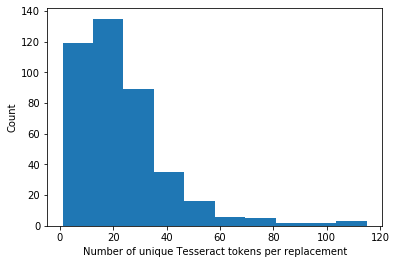

In [43]:
dissimilar_frequency_df2 = dissimilar_frequency_df.groupby("Guess", as_index = True).Tesseract.nunique()
#dissimilar_frequency_df2
#dissimilar_frequency_df2.mean()
plt.hist(dissimilar_frequency_df2)
plt.xlabel("Number of unique Tesseract tokens per replacement")
plt.ylabel("Count")

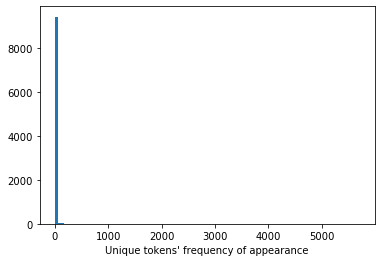

In [44]:
tesseract_frequency_dissimilar = dissimilar_frequency_df.Tesseract.value_counts()
plt.hist(tesseract_frequency_dissimilar, 100)
plt.xlabel("Unique tokens' frequency of appearance")
#plt.show suppresses the annoying array printout
plt.show()

Text(0, 0.5, 'Degree similarity (%)')

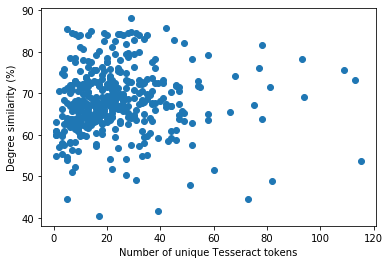

In [45]:
## agg fn allows insertion of functions or list of functions which are then returned as multindex cols
dissimilar_frequency_df3 = dissimilar_frequency_df.groupby("Guess", as_index = False).agg({
    "Tesseract": "nunique",
    "Similarity": "mean"
})
plt.scatter(dissimilar_frequency_df3.Tesseract, dissimilar_frequency_df3.Similarity)
plt.xlabel("Number of unique Tesseract tokens")
plt.ylabel("Degree similarity (%)")

Of course, some occur more frequently than others. Examples include "bway", "bklyn", "mkt", and "gwich" which we intuitively know to be Broadway, Brooklyn, Market, and Greenwich.

In [46]:
dissimilar_frequency_df.groupby("Tesseract").count().sort_values(by="Guess", ascending=False)

,Guess,Similarity
Tesseract,,
bklyn,5708,5708
pl,4416,4416
b,2638,2638
j,2408,2408
a,2366,2366
...,...,...
gerhard,1,1
geraci,1,1
georze,1,1


#### Symspell
This is an alternative to fuzzy matching that should be faster. Like fuzzy matching, it matches entries with known values from an imported dictionary that is streetnames text file. Like fuzzy matching, it is a form of character embedding.
Unlike fuzzy matching, the metric of concern here is the number of edits required to make a match. 

In [47]:
# Adding to the dictionary
sym_spell = SymSpell(max_dictionary_edit_distance=5)
sym_spell.create_dictionary(street_names_txt)
# print(sym_spell.words)

# Creating a vector of tokens
## Sample
#locations_vec = locations_tsv_trunc.token_re.tolist()
## Population
locations_vec = locations_tsv.token_re.tolist()

def replacement(tokens):

    # Creating lists to populate
    num_edits = []
    distance = []
    replacement = []
    
    # Starting replacement
    for token in tokens:
        suggestion = sym_spell.lookup(token, Verbosity.TOP, max_edit_distance = 5, include_unknown = True)
        
        for suggestions in suggestion:
            suggestitem = str(suggestions)
            suggestitem = suggestitem.split(",")
            replacement.append(suggestitem[0])
            num_edits.append(suggestitem[1])
            distance.append(suggestitem[2])
    
    # Creating a replacement df
    replacement_df = pd.DataFrame({"Tesseract": tokens,
                    "Guess": replacement,
                    "Edits": num_edits,               
                    "Similarity": distance})
    return replacement_df


In [48]:
start = timer()
replacement_df = replacement(locations_trunc_vec)
end = timer()
print(end - start)

0.09556380000049103


In [49]:
replacement_df.sort_values(by = "Similarity", ascending = True)

,Tesseract,Guess,Edits,Similarity
455,advertisement,advertisement,6,0
499,1374,13th,2,1
317,av,av,0,1
316,w,w,0,1
475,187,18th,2,1
...,...,...,...,...
413,ifth,fifth,1,6
429,third,third,0,6
232,fifth,fifth,0,6
249,second,second,0,6


#### chars2vec

https://medium.com/hackernoon/chars2vec-character-based-language-model-for-handling-real-world-texts-with-spelling-errors-and-a3e4053a147d

KeyboardInterrupt: 

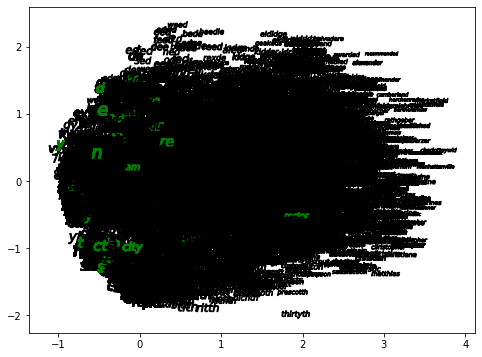

In [50]:
import chars2vec
import sklearn.decomposition

# Load model
c2v_model = chars2vec.load_model('eng_50')

# Streetnames
locations = []
locations.extend(street_names_txt)
locations.extend(locations_vec)

# Create word embeddings based on a list of location tokens
embeddings = c2v_model.vectorize_words(locations)

# Project embeddings on plane using the PCA
projection_2d = sklearn.decomposition.PCA(n_components=2).fit_transform(embeddings)

# Plot
f = plt.figure(figsize=(8, 6))
for j in range(len(projection_2d)):
    plt.scatter(projection_2d[j, 0], projection_2d[j, 1],
                marker=('$' + locations[j] + '$'),
                s=100 * len(locations[j]), label=j,
                facecolors='green' if locations[j] 
                           in street_names_txt else 'black')


### Occupations

In [ ]:
print((occupations_tsv.token.nunique()))
occupations_tsv.head(n = 20)

Some pre-processing here:  
1) Removed punctuation

In [ ]:
# function remove punctuation; converts plural to singular; removing single-lettered entries; remove names; remove completely capitalized nouns 
def clean_token(token):
    token = str(token)
    # check for names
    title_case = token.istitle()
    if title_case is True:
        token = ""
        return token
    else:
        # check and correct for punctuation
        token = ''.join(t for t in token if t.isalnum())
        # check for numbers
        numeral = token.isdigit()
        if numeral is True:
            token = ""
            return token
        # remove single entries
        if len(token) == 1: 
            token = ""
            return token
        # remove completely capitalized words because they might be from adverts
        caps = token.isupper()
        if caps is True:
            token = ""
            return token
        # check and stems plural nouns
        elif token.endswith("s"):
            token = token.rstrip("s")
            return token
        else:
            return token

# apply to column and create new column
occupations_tsv_working_copy = occupations_tsv
occupations_tsv_working_copy["token_re"] = occupations_tsv_working_copy["token"].apply(clean_token)

# drop rows with just whitespace
occupations_tsv_working_copy = occupations_tsv_working_copy.drop(occupations_tsv_working_copy[(occupations_tsv_working_copy.token_re == '')].index)

occupations_freq = occupations_tsv_working_copy["token_re"].value_counts()

In [ ]:
occupations_freq.head(n = 60)

In [ ]:
occupations_freq.sum()

Assuming that Tesseract makes text recognition errors systematically and randomly, it can therefore be expected that variations of the same word is scattered throughout the dataset. Hence, less frequently occuring words can be matched to more frequently occurring one repeatedly until it coalesces to a more "correct" list. 

In [ ]:
occupations_freq_df = pd.DataFrame(occupations_tsv_working_copy.groupby("token_re", 
                                                                        as_index = False)["token"].count()).sort_values(by = "token",
                                                                                                                        ascending = False).reset_index(drop = True)

In [ ]:
occupations_freq_q1.token.sum()

In [ ]:
# Take each quartiles and compare similarities
q1 = int(len(occupations_freq_df)/4)
occupations_freq_q4 = occupations_freq_df.tail(n = q1)
occupations_freq_q3 = occupations_freq_df.iloc[2*q1:3*q1,]
occupations_freq_q1 = occupations_freq_df.iloc[:q1, ]
occupations_freq_q234 = occupations_freq_df.iloc[q1:,]

# Reuse the fuzzy_match function from before
# Create lists for similar and dissimilar tokens
choices = occupations_freq_q1.token_re.tolist()
occ_tesseract_s = []
occ_pct_similarity_s = []
occ_best_guess_s = []
occ_tesseract_d = []
occ_pct_similarity_d = []
occ_best_guess_d = []
occ_overall_similarity = []
#def fuzzy_match(x, choices=master_street_names, scorer=fuzz.token_sort_ratio, 
#                tesseract_s = tesseract_s, pct_similarity_s = pct_similarity_s, best_guess_s = best_guess_s,
#                tesseract_d = tesseract_d, pct_similarity_d = pct_similarity_d, best_guess_d = best_guess_d)

occupations_freq_q234.loc["token_replaced"] = occupations_freq_q234["token_re"].apply(
    fuzzy_match,
    args = (choices,
            fuzz.token_sort_ratio,
            90,
            occ_tesseract_s,
            occ_pct_similarity_s,
            occ_best_guess_s,
            occ_tesseract_d,
            occ_pct_similarity_d,
            occ_best_guess_d)
)

# Put the lists from replacement fn above into a df
## Dissimilarity
occ_dissimilar_frequency_df_q234vq1 = pd.DataFrame({"Tesseract": occ_tesseract_d,
                    "Guess": occ_best_guess_d,
                    "Similarity": occ_pct_similarity_d}) 
## Similarity
occ_similar_frequency_df_q234vq1 = pd.DataFrame({"Tesseract": occ_tesseract_s,
                    "Guess": occ_best_guess_s,
                    "Similarity": occ_pct_similarity_s}) 

In [ ]:
## Similarity distribution
occ_overall_similarity = pd.concat([occ_dissimilar_frequency_df_q234vq1, occ_similar_frequency_df_q234vq1])

In [ ]:
occ_overall_similarity.extend(occ_pct_similarity_d)
occ_overall_similarity = np.array(occ_overall_similarity)
#occ_overall_similarity = pd.DataFrame(occ_overall_similarity.append(occ_pct_similarity_s))

In [ ]:
occ_overall_similarity.shape

In [ ]:
plt.hist(occ_overall_similarity.Similarity, bins = 20)
plt.show()

In [ ]:
choices = occ_similar_frequency_df_q234vq1.Tesseract.tolist()
occ_tesseract_s = []
occ_pct_similarity_s = []
occ_best_guess_s = []
occ_tesseract_d = []
occ_pct_similarity_d = []
occ_best_guess_d = []
occ_dissimilar_frequency_df_q234vq1.loc["Guess2"] = occ_dissimilar_frequency_df_q234vq1["Tesseract"].apply(
    fuzzy_match,
    args = (choices,
            fuzz.token_sort_ratio,
            80,
            occ_tesseract_s,
            occ_pct_similarity_s,
            occ_best_guess_s,
            occ_tesseract_d,
            occ_pct_similarity_d,
            occ_best_guess_d)
)
# Put the lists from replacement fn above into a df
## Dissimilarity
occ_q234_remainder_dissimilar_frequency_df = pd.DataFrame({"Tesseract": occ_tesseract_d,
                    "Guess": occ_best_guess_d,
                    "Similarity": occ_pct_similarity_d}) 
## Similarity
occ_q234_remainder_similar_frequency_df = pd.DataFrame({"Tesseract": occ_tesseract_s,
                    "Guess": occ_best_guess_s,
                    "Similarity": occ_pct_similarity_s})

In [ ]:
occ_q234_remainder_similar_frequency_df.iloc[620:680,]

In [ ]:
occ_q234_remainder_similar_frequency_df.Tesseract.value_counts().sort_values(ascending = False)

In [ ]:
occ_q234_remainder_similar_frequency_df.Guess.value_counts().sort_values(ascending = False)

In [ ]:
occ_q234_remainder_dissimilar_frequency_df.Tesseract.value_counts().sort_values(ascending = False)

Sorted by frequency of occurrence, 12% of the tokens in the bottom 75% can be mapped with a high level of confidence to those in the first quartile.   

In [ ]:
occ_similar_frequency_df_q234vq1.Tesseract.value_counts().sort_values(ascending = False)

In [ ]:
occ_similar_frequency_df_q234vq1.sort_values(by = 'Similarity')

In [ ]:
occ_similar_frequency_df_q234vq1.Guess.value_counts()

In [ ]:
# this suggests that there is great variance in Tesseract's text recognition
occ_similar_frequency_df_q234vq1.Tesseract.value_counts().sort_values(ascending = False).head(n = 50)

In [ ]:
occ_similar_frequency_df2_q234vq1 = occ_similar_frequency_df_q234vq1.groupby("Guess", as_index = True).Tesseract.nunique()
plt.hist(occ_similar_frequency_df2_q234vq1, 35)
plt.xlabel("Number of unique Tesseract tokens per replacement")
plt.ylabel("Count")

In [ ]:
occ_dissimilar_frequency_df_q234vq1.Guess.value_counts().head(n = 50)

In [ ]:
occ_dissimilar_frequency_df_q234vq1.Tesseract.value_counts()

In [ ]:
occ_similar_frequency_df_q4vq1.sort_values(by = 'Similarity')

In [ ]:
occ_dissimilar_frequency_df_q4vq1.sort_values(by="Similarity", ascending = False)

In [ ]:
occ_dissimilar_frequency_df_q4vq1.Guess.value_counts().head(n = 50)

As with the addresses, most Q3 replacements only have one corresponding Q4 token. Further, all of these tokens are unique. Previously, *dissimilarity* with addresses was positively correlated with higher variance in Tesseract's recognition of the same "correct" token. Likewise, this has occurred here where less frequently occurring tokens are part of Tesseract's recognition error.    

In [ ]:
occ_similar_frequency_df2_q4vq1 = occ_similar_frequency_df_q4vq1.groupby("Guess", as_index = True).Tesseract.nunique()
plt.hist(occ_similar_frequency_df2_q4vq1)
plt.xlabel("Number of unique Tesseract tokens per replacement")
plt.ylabel("Count")

In [ ]:
occ_tesseract_frequency = occ_similar_frequency_df.Tesseract.value_counts()
plt.hist(occ_tesseract_frequency)
plt.xlabel("Unique tokens' frequency of appearance")
#plt.show suppresses the annoying array printout
plt.show()

In [ ]:
occ_dissimilar_frequency_df.sort_values(by = "Similarity", ascending = False)

In [ ]:
int(len(occupations_freq_df)/4)
len(occupations_freq_q4)
choices = occupations_freq_q3.token_re.tolist()
choices

### Subjects/Names

In [ ]:
print(subjects_tsv.entry_uuid.nunique())
subjects_tsv.head(n = 20)

## Discarded | Obsolete Code

Initially, I thought that we might be able to correct some of the spelling errors presented by Tesseract. To test this, I applied this to a sample of occupations given that occupations are more likely to be found in a proper English dictionary than street and human names. However, the results are extremely poor due to the abbrieviations and Tesseract-errors. Furthermore, some words such as `segars` are the antiquated form of modern words such as `cigars` which the module does not pick up on. Instead, it suggests `sugars`, which is not technically wrong from a word-matching and spell-check standpoint. 

In [ ]:
# https://www.clips.uantwerpen.be/pages/pattern-en#spelling
# https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html
# https://www.nltk.org/

""""
from pattern.en import suggest

#occupations sample
occupations_sample = occupations_freq_res.loc[:, ["original"]].sample(n = 100)
occupations_freq_res = occupations_freq.reset_index()
occupations_freq_res = occupations_freq_res.rename(columns = {"index": "original"})
occupations_freq_res = occupations_freq_res.astype({"original": str})

# spellcheck function with suggest
def spellcheck(token):
    digit_check = token.isdigit()
    if digit_check is True:
        return token
    else:
        checked = suggest(token)
        return checked
    
# Apply to sample
occupations_sample["corrected"] = occupations_sample["original"].apply(spellcheck)

# Glimpse into result
occupations_sample.head(n = 60)
""""

[Link](https://stackoverflow.com/questions/40712178/reading-the-json-file-with-multiple-objects-in-python) to help with decoding this particular JSON object. Multiple JSON object within one.

In [ ]:
# Opens the file and saves it to a pandas df
##with open(path + test_json) as f:
##    df = pd.read_json(f, lines=True)

In [ ]:
# Quick look into the JSON table to check
##df.tail()

In [ ]:
# Manual uniqueness check
##line_number = np.array(df.original_hocr_line_number)
##unique_elements, counts_elements = np.unique(line_number, return_counts=True)
##print("Frequency of unique values of the said array:")
##print(np.asarray((unique_elements, counts_elements)))

Labels "a", "h", and "r" represent the relative addresses, and address types such as houses, and rear.

In [ ]:
# Quick glimpse of how the last column might actually look like
## df.iloc[124,-1]

In [ ]:
##df.iloc[110,-1]

In [ ]:
##df.iloc[10,-1]

In [ ]:
##df.iloc[4,-1]

In [ ]:
##df.iloc[147, -1]

In [ ]:
##df_labeled_entry = df.labeled_entry.apply(pd.Series)
##df_locations = df_labeled_entry["locations"]
##df_locations = pd.concat([df_locations, df.original_hocr_line_number], axis = 1)

In [ ]:
##df_locations

In [ ]:
##df_locations.iloc[147,:]

In [ ]:
##type(df_locations.iloc[147,0])

In [ ]:
##type(df_locations.iloc[147,0][1])

In [ ]:
##df_locations.iloc[147][0]

In other words, each labeled entry's location is stored as a list of _n_ dictionaries with two key-value pairs of `value` and `labels`.

In [ ]:
##df_locations.iloc[3][0]

In [ ]:
##type(df_locations)

In [ ]:
# This checks for existence of labels, duly records the (non)existence, strips it out, appends to another list
# This is done w/o loss to order

#line_num_list = []
#complete_street_name = []
#split_street_name = []
#labels = []
#for entry in range(0,len(df_locations)):
#    #print(df_locations.iloc[entry])
#    for dicts in df_locations.iloc[entry][0]:
#        if 'labels' in dicts:
#            for key, value in dicts.items():
#                #line_num_list.append(df_locations.iloc[entry][1])
#                if key == 'labels':
#                    labels.append(value)
#                else:
#                    complete_street_name.append(value)
#                    street_name_split = str(value).split()
#                    split_street_name.append(street_name_split)
#                    line_num_list.append(df_locations.iloc[entry][1])
#        else:
#            for key, value in dicts.items():
#                line_num_list.append(df_locations.iloc[entry][1])
#                labels.append(" ")
#                complete_street_name.append(value)
#                street_name_split = str(value).split()
#                split_street_name.append(street_name_split)


It appears that avenues are spelled out and streets are enumerated.

In [ ]:
#split_street_name

In [ ]:
#unlisted_location = pd.concat([pd.Series(complete_street_name), pd.Series(split_street_name), pd.Series(labels), pd.Series(line_num_list)], axis = 1)
#unlisted_location.columns = ["complete_street_name", "split_street_name", "labels", "line_number"]

In [ ]:
#len(line_num_list)

In [ ]:
#unlisted_location

In [ ]:
# first order of business is to test if string is a street number
# if it is not, then it is probably a street name, and a comparison can be made
# Perform regex to remove the periods
# https://www.datacamp.com/community/tutorials/fuzzy-string-python
# https://datascience.stackexchange.com/questions/29775/how-to-check-and-correct-misspelling-in-the-data-of-pairs-of-words
# http://blog.keyrus.co.uk/fuzzy_matching_101_part_i.html
# http://blog.keyrus.co.uk/fuzzy_matching_101_part_ii.html

#for i in range(0, len(unlisted_location)):
#    non_numeric_street_name = []
#    for address_component in unlisted_location.iloc[i, 1]:
#        if address_component.isnumeric() == False:
#            non_numeric_street_name.append(address_component)
#            print(non_numeric_street_name)
#        unlisted_location.iloc[i]["non_numeric"] = non_numeric_street_name
            
#        #print(address_component.isnumeric())


In [ ]:
#unlisted_location